#### <b>Download the pre-trained StyleGAN weights</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-StyleGAN-Face-Editting
%cd PyTorch-StyleGAN-Face-Editting
!unzip weights/karras2019stylegan-ffhq-1024x1024.zip -d weights/

Cloning into 'PyTorch-StyleGAN-Face-Editting'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 112 (delta 24), reused 43 (delta 1), pack-reused 30
Receiving objects: 100% (112/112), 95.16 MiB | 54.87 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/PyTorch-StyleGAN-Face-Editting
Archive:  weights/karras2019stylegan-ffhq-1024x1024.zip
  inflating: weights/karras2019stylegan-ffhq-1024x1024.pt  


#### <b>Download celebrity face images</b>

In [2]:
!git clone https://github.com/ndb796/StyleGAN-Embedding-PyTorch
!cp -r StyleGAN-Embedding-PyTorch/celeba_hq_validation_100_encoded_latents/ celeba_hq_validation_100_encoded_latents/

Cloning into 'StyleGAN-Embedding-PyTorch'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (520/520), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 520 (delta 23), reused 478 (delta 6), pack-reused 0
Receiving objects: 100% (520/520), 62.44 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (23/23), done.


#### <b>Load required libraries</b>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

#### <b>Load StyleGAN model</b>

In [4]:
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

#### <b>Define utilities</b>

In [5]:
# Read an image from a file
def image_reader(image_path, resize=None):
    with open(image_path, "rb") as f:
        image = Image.open(f)
        image = image.convert("RGB")
    if resize != None:
        image = image.resize((resize, resize))
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 1]
    ])
    image = transform(image)
    image = image.unsqueeze(0) # (N, C, H, W)
    return image


# Show a torch image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
        gray_scale = True
    image = transforms.ToPILImage()(image)
    if gray_scale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# Change the display resolution
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

#### <b>Face morphing experiments</b>

[ Face Interpolation ]


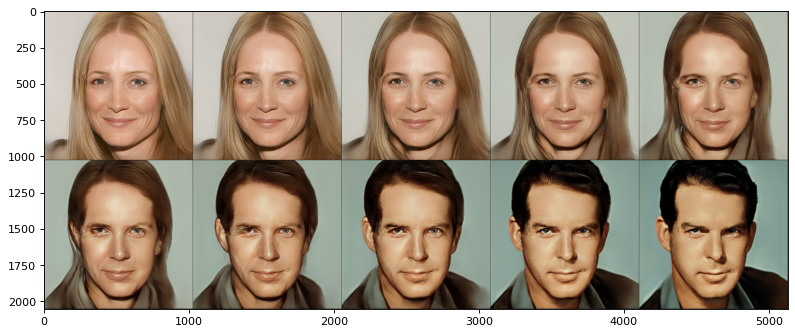

In [13]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./celeba_hq_validation_100_encoded_latents/female/000431_latent.npy')
w_2 = np.load('./celeba_hq_validation_100_encoded_latents/male/000080_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Face Interpolation ]


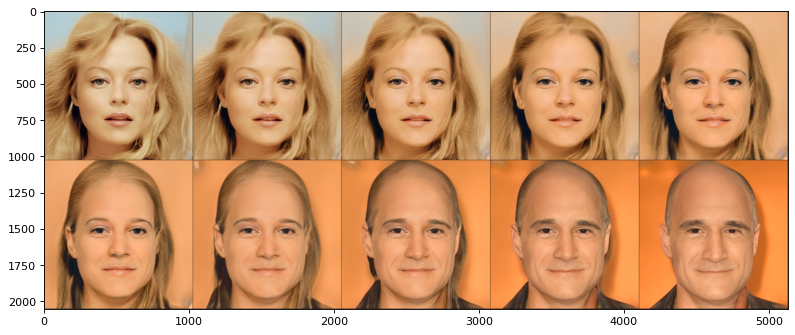

In [14]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./celeba_hq_validation_100_encoded_latents/female/002292_latent.npy')
w_2 = np.load('./celeba_hq_validation_100_encoded_latents/male/002528_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

#### <b>Read all images</b>

In [8]:
import os
import torch.utils.data as data


class CustomDataset(data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images[idx])
        image_name = self.images[idx].split('_latent.npy')[0]
        return np.load(image_path), image_name


male_dataset = CustomDataset('./celeba_hq_validation_100_encoded_latents/male')
female_dataset = CustomDataset('./celeba_hq_validation_100_encoded_latents/female')

male_train_dataloader = data.DataLoader(male_dataset , batch_size=4, shuffle=False, num_workers=4)
female_train_dataloader = data.DataLoader(female_dataset , batch_size=4, shuffle=False, num_workers=4)

#### <b>Forwarding experiments</b>

In [9]:
!mkdir -p ./outputs/male
!mkdir -p ./outputs/female

In [10]:
save_path = './outputs/male/'

for step, (latents, names) in enumerate(male_train_dataloader):
    latents = latents.to(device)

    generated_images = g_synthesis(latents)
    generated_images = ((generated_images + 1.0) / 2.0).clamp(0, 1)
    
    for i in range(generated_images.shape[0]):
        save_image(generated_images[i], save_path + f'{names[i]}.png')

In [11]:
save_path = './outputs/female/'

for step, (latents, names) in enumerate(female_train_dataloader):
    latents = latents.to(device)

    generated_images = g_synthesis(latents)
    generated_images = ((generated_images + 1.0) / 2.0).clamp(0, 1)
    
    for i in range(generated_images.shape[0]):
        save_image(generated_images[i], save_path + f'{names[i]}.png')

In [12]:
!zip -r man_compressed.zip ./outputs/male/*.png
!zip -r female_compressed.zip ./outputs/female/*.png

  adding: outputs/male/000080.png (deflated 0%)
  adding: outputs/male/000143.png (deflated 0%)
  adding: outputs/male/000196.png (deflated 0%)
  adding: outputs/male/000406.png (deflated 0%)
  adding: outputs/male/000443.png (deflated 0%)
  adding: outputs/male/000534.png (deflated 0%)
  adding: outputs/male/000622.png (deflated 0%)
  adding: outputs/male/000801.png (deflated 0%)
  adding: outputs/male/000990.png (deflated 0%)
  adding: outputs/male/001022.png (deflated 0%)
  adding: outputs/male/001036.png (deflated 0%)
  adding: outputs/male/001074.png (deflated 0%)
  adding: outputs/male/001092.png (deflated 0%)
  adding: outputs/male/001693.png (deflated 0%)
  adding: outputs/male/001804.png (deflated 0%)
  adding: outputs/male/002123.png (deflated 0%)
  adding: outputs/male/002317.png (deflated 0%)
  adding: outputs/male/002378.png (deflated 0%)
  adding: outputs/male/002528.png (deflated 0%)
  adding: outputs/male/002708.png (deflated 0%)
  adding: outputs/male/002768.png (defla